## TODO: Explain me!

In [36]:
# Hyperparams for specific model. Change accordingly.
N_BLOCKS = 6
N_HEADS = 6

In [37]:
"""
Sample from the trained model with PyTorch
"""
import json
from contextlib import nullcontext
import torch
import os, sys
from pathlib import Path

# Support absolute imports for a standalone script
sys.path.insert(0, Path.cwd().parent.as_posix())


from model import ModelArgs, Transformer, softmax_sum
from tokenizer import Tokenizer
from tinystories import get_tokenizer_model_path

# -----------------------------------------------------------------------------
start = "" # or "<|endoftext|>" or etc. Can also specify a file, use as: "FILE:prompt.txt"
max_new_tokens = 25 # number of tokens generated in each sample
temperature = 0 # 1.0 = no change, < 1.0 = less random, > 1.0 = more random, in predictions
top_k = 300 # retain only the top_k most likely tokens, clamp others to have 0 probability
tokenizer = "" # override the tokenizer model path
seed = 1337
device = 'cuda' if torch.cuda.is_available() else 'cpu' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1', etc.
#dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32' or 'bfloat16' or 'float16'
dtype = "float16"
compile = False # use PyTorch 2.0 to compile the model to be faster

softmax0_run = 'softmax0-15m-2023_08_26_00_08_49'
softmax1_run = 'softmax1-15m-2023_08_25_11_47_04'
softmax1_110m_run = 'artifacts/l83srejz_model:v49'
# -----------------------------------------------------------------------------

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

def load_model(out_dir):
    # init from a model saved in a specific directory
    checkpoint_dict = torch.load(f"{out_dir}/ckpt.pt", map_location=device)
    # del flash if exists
    if 'flash' in checkpoint_dict['model_args']:
        del checkpoint_dict['model_args']['flash']
    # softmax -> softmax1 in model_args
    if 'softmax' in checkpoint_dict['model_args']:
        checkpoint_dict['model_args']['softmax1'] = checkpoint_dict['model_args']['softmax']
        del checkpoint_dict['model_args']['softmax']
    gptconf = ModelArgs(**checkpoint_dict['model_args'])
    model = Transformer(gptconf)
    state_dict = checkpoint_dict['model']
    unwanted_prefix = '_orig_mod.'
    for k,v in list(state_dict.items()):
        if k.startswith(unwanted_prefix):
            state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
    model.load_state_dict(state_dict, strict=False)

    model.eval()
    model.to(device)
    if compile:
        print("Compiling the model...")
        model = torch.compile(model) # requires PyTorch 2.0 (optional)
    
    return model

def load_tokenizer(out_dir):
    # load the tokenizer
    with open(f"{out_dir}/config.json", 'r') as f:
        config = json.load(f)
    vocab_source = config.get("vocab_source", "llama2")
    vocab_size = config['vocab_size']
    if tokenizer:
        # a specific tokenizer is provided, use it
        tokenizer_model = tokenizer
    else:
        # let's try to find the tokenizer model automatically. bit gross here...
        query_vocab_size = 0 if vocab_source == "llama2" else vocab_size
        tokenizer_model = get_tokenizer_model_path(vocab_size=query_vocab_size)
    enc = Tokenizer(tokenizer_model='../tokenizer.model')
    return enc

model_softmax0 = load_model(f'../out/{softmax0_run}')
model_softmax1 = load_model(f'../out/{softmax1_run}')
model_softmax1_110m = load_model(f'../{softmax1_110m_run}')
enc = load_tokenizer(f'../out/{softmax0_run}')

def encode_prompt(start):
    if start.startswith('FILE:'):
        with open(start[5:], 'r', encoding='utf-8') as f:
            start = f.read()
    start_ids = enc.encode(start, bos=True, eos=False)
    x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])
    return x

# run generation
@torch.no_grad()
def generate(model=model_softmax1, prompt=start, max_new_tokens=max_new_tokens, temperature=temperature, top_k=top_k,
             split_token=False):
    x = encode_prompt(prompt)
    with ctx:
        y = model.generate(x, max_new_tokens, temperature, top_k)
        if split_token:
            return [enc.decode([token]) for token in y.tolist()[0]]
        return enc.decode(y.tolist())[0]

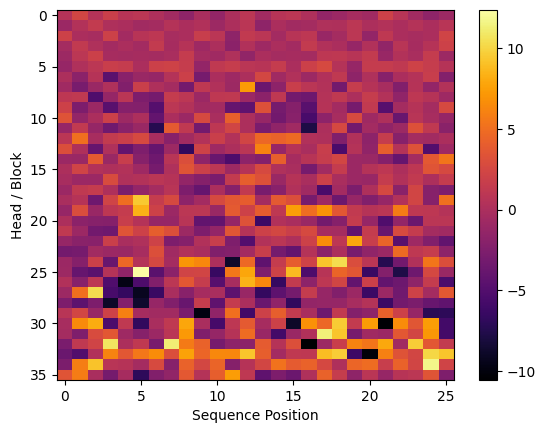

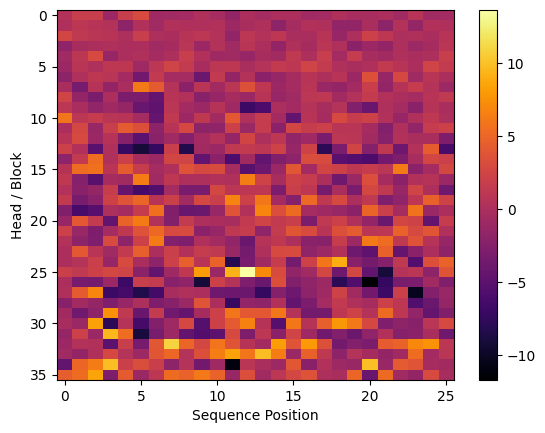

In [38]:
prompt = "Sally sold seashells"
max_new_tokens = 20

generate(
    model=model_softmax0, prompt=prompt, max_new_tokens=max_new_tokens, split_token=True
)

from model import v_act

wv_sums = torch.stack(v_act).sum(dim=-1).reshape(N_HEADS * N_BLOCKS, -1)

plt.imshow(wv_sums, aspect="auto", cmap="inferno")
plt.xlabel("Sequence Position")
plt.ylabel("Head / Block")
plt.colorbar()
plt.show()

generate(
    model=model_softmax1, prompt=prompt, max_new_tokens=max_new_tokens, split_token=True
)

from model import v_act

wv_sums = torch.stack(v_act).sum(dim=-1).reshape(N_HEADS * N_BLOCKS, -1)

plt.imshow(wv_sums, aspect="auto", cmap="inferno")
plt.xlabel("Sequence Position")
plt.ylabel("Head / Block")
plt.colorbar()

torch.Size([36, 48])


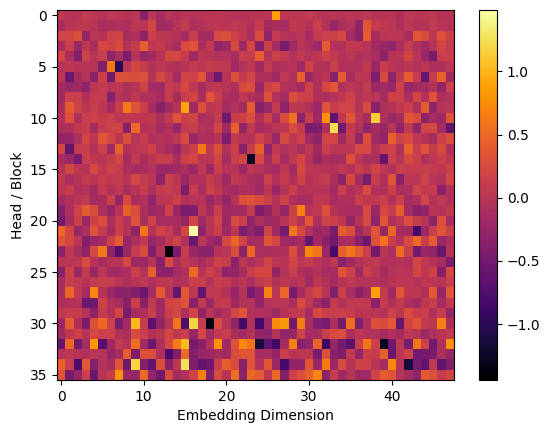

torch.Size([36, 48])


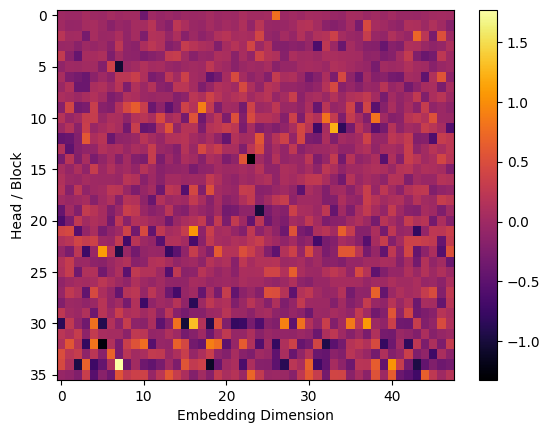

In [40]:
prompt = "Sally sold seashells"
max_new_tokens = 20

generate(
    model=model_softmax0, prompt=prompt, max_new_tokens=max_new_tokens, split_token=True
)

from model import v_act

# wv embedding dimension for all <bos>, per head/block
wv_bos0 = torch.stack(v_act)[:, :, 0, :].reshape(N_HEADS * N_BLOCKS, -1)
print(wv_bos.shape)

plt.imshow(wv_bos0, aspect="auto", cmap="inferno")
plt.xlabel("Embedding Dimension")
plt.ylabel("Head / Block")
plt.colorbar()
plt.show()

generate(
    model=model_softmax1, prompt=prompt, max_new_tokens=max_new_tokens, split_token=True
)

from model import v_act

# wv embedding dimension for all <bos>, per head/block
wv_bos1 = torch.stack(v_act)[:, :, 0, :].reshape(N_HEADS * N_BLOCKS, -1)
print(wv_bos.shape)

plt.imshow(wv_bos1, aspect="auto", cmap="inferno")
plt.xlabel("Embedding Dimension")
plt.ylabel("Head / Block")
plt.colorbar()
plt.show()

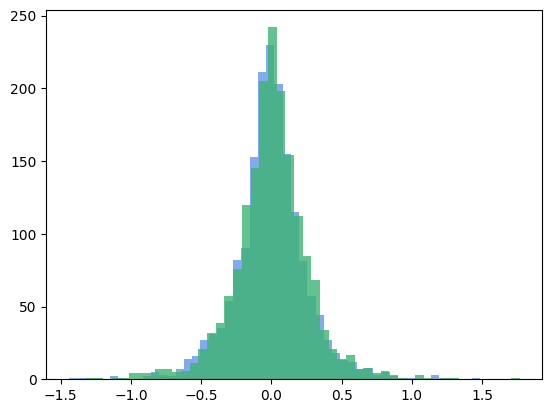

In [41]:
plt.hist(wv_bos0.flatten(), bins=50, color="cornflowerblue", alpha=0.8)
plt.hist(wv_bos1.flatten(), bins=50, color="mediumseagreen", alpha=0.8)
plt.show()

In [42]:
wv_bos0.flatten().mean().item(), wv_bos1.flatten().mean().item()

(-0.005214002449065447, 0.0030768106225878)

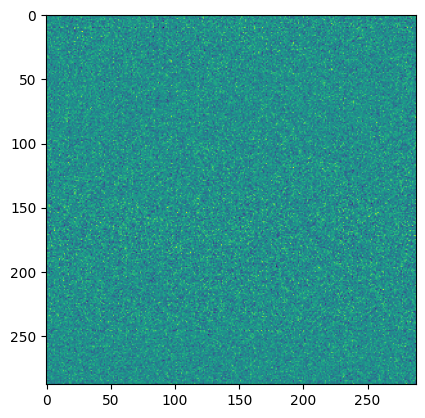

In [43]:
plt.imshow(model_softmax0.layers[0].attention.wv.weight.detach().cpu().numpy())
plt.show()

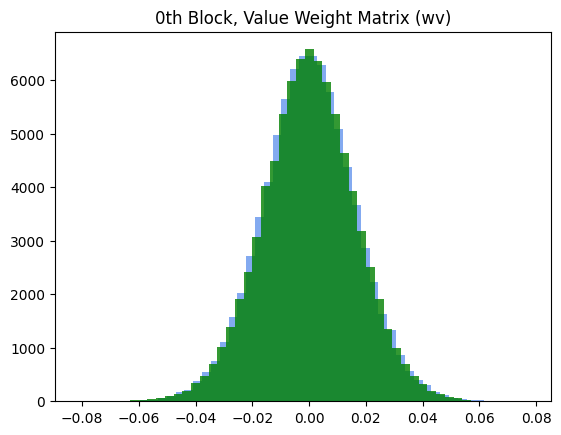

In [44]:
wv0_blocks = torch.stack(
    [
        block.attention.wv.weight.detach().cpu().flatten()
        for block in model_softmax0.layers
    ]
)
wv1_blocks = torch.stack(
    [
        block.attention.wv.weight.detach().cpu().flatten()
        for block in model_softmax1.layers
    ]
)

plt.hist(wv0_blocks[0], bins=50, color="cornflowerblue", alpha=0.8)
plt.hist(wv1_blocks[0], bins=50, color="green", alpha=0.8)
plt.title(f"0th Block, Value Weight Matrix (wv)")
plt.show()

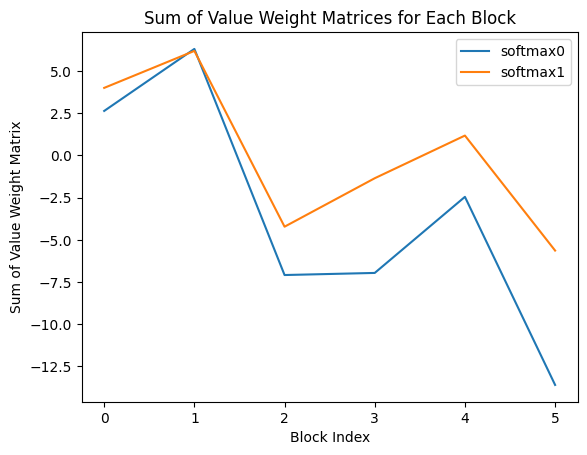

In [45]:
wv0_sums = [
    model_softmax0.layers[i].attention.wv.weight.detach().cpu().sum().item()
    for i in range(6)
]
wv1_sums = [
		model_softmax1.layers[i].attention.wv.weight.detach().cpu().sum().item()
		for i in range(6)
]

# Plot the sums of the value weight matrices for each block
plt.plot(wv0_sums, label="softmax0")
plt.plot(wv1_sums, label="softmax1")
plt.title("Sum of Value Weight Matrices for Each Block")
plt.xlabel("Block Index")
plt.ylabel("Sum of Value Weight Matrix")
plt.legend()
plt.show()